[![Commits since latest release][gh-image]][gh-link]

[gh-link]: https://github.com/claudioperez/elle-0002/compare/v0.0.0...master
[gh-image]: https://img.shields.io/github/commits-since/claudioperez/elle-0002/v0.0.0?style=social

In [5]:
import anon.conf
anon.conf.config.update('jax_disable_jit', True)
import anon
import jax
import anon.atom as anp
import elle.sections
import elle.beam2d
import elle.springs
import emme as em
mat = elle.springs.isokin.no1(60.0,29e3)
sec = elle.sections.core_v2.Rectangle
geom_template = elle.beam2d.transform_no2(elle.beam2d.geom_no2,_jit=True)
beam_template = elle.beam2d.resp_no6

An `Assembler` is an object with an `.assemble()` and optionally a `.compose()` method

In [6]:
# Create a model Assembler
model = em.SkeletalModel(ndm=2,ndf=3)

# Define problem parameters
P1 = model.param("P1")

# Define model components
girder_section = sec(d=20.0, b=18.0,mat=mat).assemble()
column_section = sec(d=20.0, b=18.0,mat=mat).assemble()
basic_girder  = beam_template(*[girder_section]*4, quad={"n": 4, "rule": "lobatto"})
basic_column  = beam_template(*[column_section]*4, quad={"n": 4, "rule": "lobatto"})

girder = geom_template(basic_girder)
column = geom_template(basic_column)

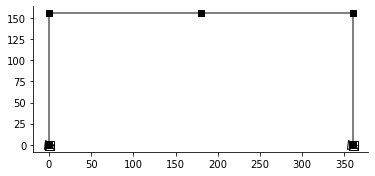

In [7]:
# Set up nodes
ft = 12
B, H = 30.*ft, 13.*ft
model.node("1",  0.,  0.)
model.node("2",  0.,  H )
model.node("3", B/2,  H )
model.node("4",  B ,  H )
model.node("5",  B ,  0.)

model.beam("a", "1", "2", elem=column)
model.beam("b", "2", "3", elem=girder)
model.beam("c", "3", "4", elem=girder)
model.beam("d", "4", "5", elem=column)

model.boun("1", [1,1,1])
model.boun("5", [1,1,1])

model.load("2", P1, dof="x")
model.load("2", -10e3, dof="y")
model.load("2", -10e3, dof="y")

em.plot_structure(model);

In [8]:
f = model.compose(_jit_force=True)
f(20e3)

[(DeviceArray([[0.],
             [0.]], dtype=float64), DeviceArray([[ 0.],
             [-0.]], dtype=float64), {'...': [{'e': 0.0, 'ep': 0.0, 'sigma': 0.0, 'q': 0.0, 'Y': 29000.0, 'solver': None}, {'e': 0.0, 'ep': 0.0, 'sigma': 0.0, 'q': 0.0, 'Y': 29000.0, 'solver': None}, {'e': 0.0, 'ep': 0.0, 'sigma': 0.0, 'q': 0.0, 'Y': 29000.0, 'solver': None}, {'e': 0.0, 'ep': 0.0, 'sigma': 0.0, 'q': 0.0, 'Y': 29000.0, 'solver': None}]}), (DeviceArray([[0.],
             [0.]], dtype=float64), DeviceArray([[ 0.],
             [-0.]], dtype=float64), {'...': [{'e': 0.0, 'ep': 0.0, 'sigma': 0.0, 'q': 0.0, 'Y': 29000.0, 'solver': None}, {'e': 0.0, 'ep': 0.0, 'sigma': 0.0, 'q': 0.0, 'Y': 29000.0, 'solver': None}, {'e': 0.0, 'ep': 0.0, 'sigma': 0.0, 'q': 0.0, 'Y': 29000.0, 'solver': None}, {'e': 0.0, 'ep': 0.0, 'sigma': 0.0, 'q': 0.0, 'Y': 29000.0, 'solver': None}]}), (DeviceArray([[0.],
             [0.]], dtype=float64), DeviceArray([[ 0.],
             [-0.]], dtype=float64), {'...': [{'e': 0.0, 

UnexpectedTracerError: Encountered an unexpected tracer. Perhaps this tracer escaped through global state from a previously traced function.
The functions being transformed should not save traced values to global state. Detail: Different traces at same level: Traced<ConcreteArray(0.0)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray(0., dtype=float64)
       tangent = Traced<ShapedArray(float64[])>with<BatchTrace(level=1/0)>
                   with val = DeviceArray([ 0.00555556, -0.16527778, -0.08194444], dtype=float64)
                        batch_dim = 0, JVPTrace(level=2/0).
To catch the leak earlier, try setting the environment variable JAX_CHECK_TRACER_LEAKS or using the `jax.checking_leaks` context manager.

In [ ]:
with jax.checking_leaks():
    f(20e3)

In [ ]:
fig, ax = em.plot_displ(model, f(29e6,29e6,20e3),scale=1e3)

In [ ]:
df = anon.diff.jacfwd(f, None, (0,1),squeeze=False)

In [ ]:
df(29e6,29e6,20e3)